In [1]:
pip install yfinance pandas numpy matplotlib scipy scikit-learn

In [2]:
pip install fredapi

[*********************100%***********************]  1 of 1 completed


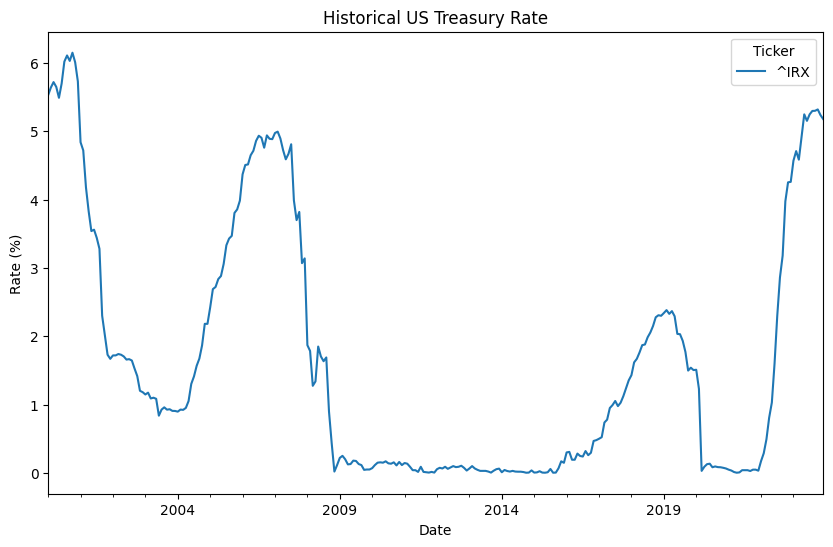

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Fetch historical data of a relevant short-term interest rate (e.g., US Treasury rate or LIBOR)
# Example: Fetching US 10-Year Treasury Rate (symbol: ^IRX) from Yahoo Finance
ticker = "^IRX"  # This is just an example, you can change it based on your data source
data = yf.download(ticker, start="2000-01-01", end="2024-01-01", interval="1mo")
data = data['Adj Close']  # Use the adjusted close price (interest rate data)
data.dropna(inplace=True)

# Plot the data to visualize it
data.plot(figsize=(10, 6))
plt.title("Historical US Treasury Rate")
plt.xlabel("Date")
plt.ylabel("Rate (%)")
plt.show()

In [4]:
import numpy as np
from scipy.optimize import minimize

# Helper function to calculate log-likelihood for Vasicek model
def vasicek_log_likelihood(params, rates):
    theta, mu, sigma = params
    dt = 1  # Time step (monthly data)
    r = rates.values
    log_likelihood = 0
    for t in range(1, len(r)):
        # Vasicek model SDE approximation
        dr = r[t] - r[t-1]
        expected_dr = theta * (mu - r[t-1]) * dt
        likelihood = -0.5 * (np.log(2 * np.pi * sigma**2 * dt) + ((dr - expected_dr)**2) / (sigma**2 * dt))
        log_likelihood += likelihood
    return -log_likelihood  # Negative log-likelihood for minimization

# Estimate parameters using MLE
initial_guess = [0.1, np.mean(data), 0.01]  # Initial guess for parameters
result = minimize(vasicek_log_likelihood, initial_guess, args=(data,))
vasicek_params = result.x
print(f"Vasicek Model Parameters: {vasicek_params}")

Vasicek Model Parameters: [ 3.44198596e-06 -3.73177466e+02  2.14409180e-01]


<ipython-input-5-97f26da9c9db>:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rates[0] = r0


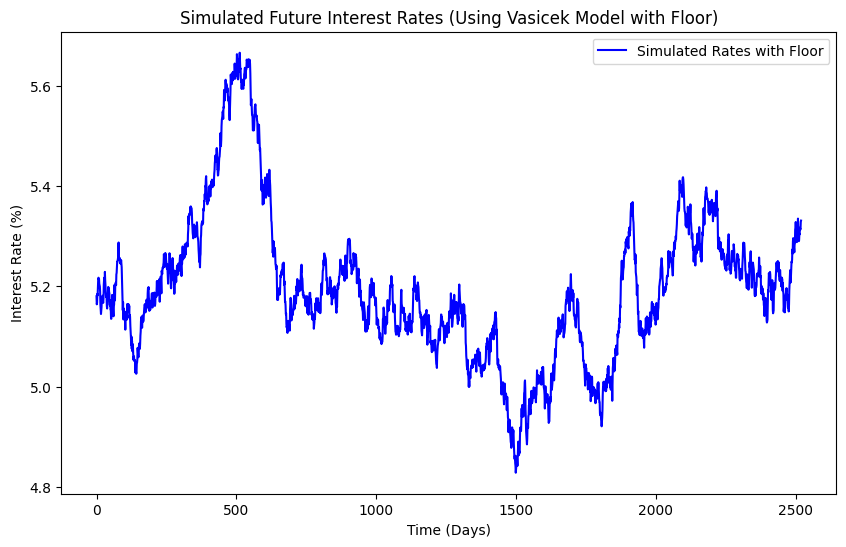

In [5]:
# Function to simulate future rates using the Vasicek model with a floor
def vasicek_model(r0, a, b, sigma, T, dt=1/252, rate_floor=0.0):
    n_steps = int(T / dt)
    rates = np.zeros(n_steps)
    rates[0] = r0
    for t in range(1, n_steps):
        # Calculate rate change
        dr = a * (b - rates[t - 1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        # Ensure the rate stays above the floor value
        rates[t] = max(rate_floor, rates[t - 1] + dr)
    return rates

# Use the last observed rate as the starting point (r0)
r0 = data.iloc[-1]  # Last observed rate
T = 10  # Forecast period in years
rate_floor = 0.0  # Define the floor rate (e.g., 0%)

# Simulate future interest rates
vasicek_simulated_rates = vasicek_model(r0, *vasicek_params, T, rate_floor=rate_floor)

# Plot the simulated interest rate paths
plt.figure(figsize=(10, 6))
plt.plot(vasicek_simulated_rates, label="Simulated Rates with Floor", color="blue")
plt.title("Simulated Future Interest Rates (Using Vasicek Model with Floor)")
plt.xlabel("Time (Days)")
plt.ylabel("Interest Rate (%)")
plt.legend()
plt.show()

<ipython-input-17-4e5ef705f0a3>:12: RuntimeWarning: divide by zero encountered in log
  likelihood = -0.5 * (np.log(2 * np.pi * sigma**2 * dt) + ((dr - expected_dr)**2) / (sigma**2 * dt))
<ipython-input-17-4e5ef705f0a3>:12: RuntimeWarning: divide by zero encountered in divide
  likelihood = -0.5 * (np.log(2 * np.pi * sigma**2 * dt) + ((dr - expected_dr)**2) / (sigma**2 * dt))
<ipython-input-17-4e5ef705f0a3>:12: RuntimeWarning: invalid value encountered in add
  likelihood = -0.5 * (np.log(2 * np.pi * sigma**2 * dt) + ((dr - expected_dr)**2) / (sigma**2 * dt))
<ipython-input-17-4e5ef705f0a3>:12: RuntimeWarning: invalid value encountered in divide
  likelihood = -0.5 * (np.log(2 * np.pi * sigma**2 * dt) + ((dr - expected_dr)**2) / (sigma**2 * dt))
<ipython-input-34-97f26da9c9db>:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rates[0] = r0


RMSE: 1.5269672297091652, MAE: 0.9384299633475567


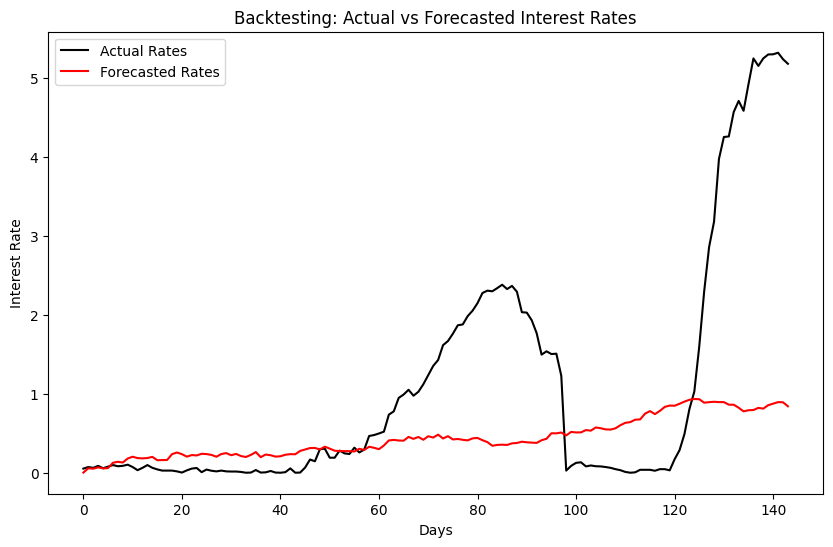

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.optimize import minimize

# Backtesting period
split_ratio = 0.5
split_index = int(len(data) * split_ratio)

# Use initial 70% of data to estimate parameters
train_data = data[:split_index]
test_data = data[split_index:]

# Re-estimate parameters on training data
initial_guess = [0.1, 0.03, 0.02]  # Example initial guess for a, b, sigma

# Minimize the negative log-likelihood function
result_train = minimize(vasicek_nll, initial_guess, args=(train_data,), method='L-BFGS-B', bounds=[(0, None), (0, None), (0, None)])
a_train, b_train, sigma_train = result_train.x

# Forecast interest rates over the test period
r0_test = train_data.iloc[-1]  # Start at the last rate of the training data
T_test = len(test_data) / 252  # Length of test period in years
forecasted_rates = vasicek_model(r0_test, a_train, b_train, sigma_train, T_test, dt=1/252)

# Calculate RMSE and MAE between forecasted and actual test data
rmse = np.sqrt(mean_squared_error(test_data, forecasted_rates))
mae = mean_absolute_error(test_data, forecasted_rates)
print(f"RMSE: {rmse}, MAE: {mae}")

# Plot actual vs. forecasted rates
plt.figure(figsize=(10, 6))
plt.plot(test_data.values, label="Actual Rates", color="black")
plt.plot(forecasted_rates, label="Forecasted Rates", color="red")
plt.title("Backtesting: Actual vs Forecasted Interest Rates")
plt.xlabel("Days")
plt.ylabel("Interest Rate")
plt.legend()
plt.show()

Ticker
^IRX    1.654243
dtype: float64 <class 'pandas.core.series.Series'>


<ipython-input-49-cef40146fe53>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_guess = np.array([0.1, float(mu_value), 0.01])  # Explicitly convert to float
<ipython-input-49-cef40146fe53>:23: RuntimeWarning: divide by zero encountered in log
  likelihood = -0.5 * (np.log(2 * np.pi * sigma**2 * dt) + ((dr - expected_dr)**2) / (sigma**2 * dt))
<ipython-input-49-cef40146fe53>:23: RuntimeWarning: divide by zero encountered in divide
  likelihood = -0.5 * (np.log(2 * np.pi * sigma**2 * dt) + ((dr - expected_dr)**2) / (sigma**2 * dt))
<ipython-input-49-cef40146fe53>:23: RuntimeWarning: invalid value encountered in add
  likelihood = -0.5 * (np.log(2 * np.pi * sigma**2 * dt) + ((dr - expected_dr)**2) / (sigma**2 * dt))
<ipython-input-49-cef40146fe53>:23: RuntimeWarning: invalid value encountered in divide
  likelihood = -0.5 * (np.log(2 * np.pi * sigma**2 * dt) + ((dr - expected_dr)*

Optimized parameters from cross-validation: theta=0.0, mu=1.6549883371162162, sigma=0.7586672997269379


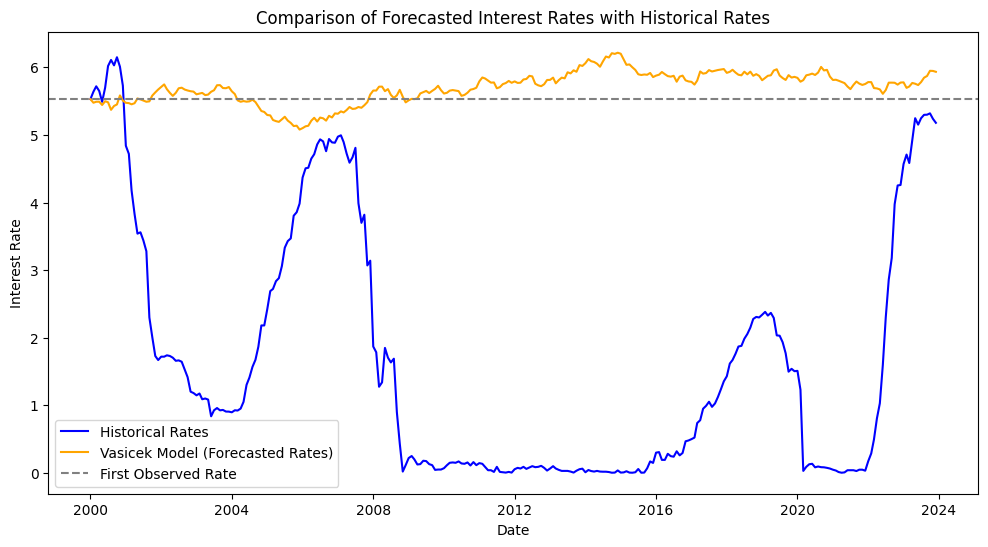

RMSE between historical and forecasted rates: 4.5069


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Function to simulate future rates using the Vasicek model with a floor
def vasicek_model(r0, a, b, sigma, T, dt=1/252, rate_floor=0.0):
    n_steps = int(T / dt)
    rates = np.zeros(n_steps)
    rates[0] = r0
    for t in range(1, n_steps):
        # Calculate rate change
        dr = a * (b - rates[t - 1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        # Ensure the rate stays above the floor value
        rates[t] = max(rate_floor, rates[t - 1] + dr)
    return rates

# Helper function to calculate log-likelihood for Vasicek model with regularization
def vasicek_log_likelihood(params, rates, regularization_strength=0.01):
    theta, mu, sigma = params
    dt = 1  # Time step (monthly data)
    r = rates.values
    log_likelihood = 0
    for t in range(1, len(r)):
        # Vasicek model SDE approximation
        dr = r[t] - r[t-1]
        expected_dr = theta * (mu - r[t-1]) * dt
        likelihood = -0.5 * (np.log(2 * np.pi * sigma**2 * dt) + ((dr - expected_dr)**2) / (sigma**2 * dt))
        log_likelihood += likelihood

    # Add L2 regularization term to penalize large values of the parameters
    regularization_penalty = regularization_strength * (theta**2 + mu**2 + sigma**2)

    # Return the negative log-likelihood with the regularization penalty
    return -log_likelihood + regularization_penalty

# Cross-validation function for parameter optimization with regularization
def cross_validate_vasicek(data, initial_guess, n_splits=5, regularization_strength=0.01):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_score = float('inf')
    best_params = None

    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]

        # Optimize parameters on training data
        result = minimize(vasicek_log_likelihood, initial_guess, args=(train_data, regularization_strength),
                          method='L-BFGS-B', bounds=[(0, None), (None, None), (0, None)])

        theta_opt, mu_opt, sigma_opt = result.x

        # Forecast interest rates over the test period using the optimized parameters
        r0_test = train_data.iloc[-1]  # Start at the last rate of the training data
        T_test = len(test_index) / 252  # Length of test period in years
        forecasted_rates = vasicek_model(r0_test, theta_opt, mu_opt, sigma_opt, T_test, dt=1/252)

        # Calculate RMSE for the test period
        rmse = mean_squared_error(data.iloc[test_index], forecasted_rates[:len(test_index)], squared=False)  # RMSE

        # If this RMSE is the best we've seen, keep these parameters
        if rmse < best_score:
            best_score = rmse
            best_params = (theta_opt, mu_opt, sigma_opt)

    return best_params

# Check the type of the mean value and print it
mu_value = data.mean()  # This should be a scalar
print(mu_value, type(mu_value))  # Check if it's a scalar

# Ensure the initial guess is a proper numpy array with scalars
initial_guess = np.array([0.1, float(mu_value), 0.01])  # Explicitly convert to float

# Run cross-validation to find the best parameters
best_params = cross_validate_vasicek(data, initial_guess)
theta_opt, mu_opt, sigma_opt = best_params
print(f"Optimized parameters from cross-validation: theta={theta_opt}, mu={mu_opt}, sigma={sigma_opt}")

# Historical data length in months (288 months)
historical_length = len(data)

# Ensure the forecast length matches the historical data length
forecast_length = historical_length  # Same length as historical data

# Generate forecasted rates (ensure you have enough forecasted rates)
forecasted_rates = vasicek_forecasted_rates[:forecast_length]  # Get the required number of forecasted rates

# Use the same dates as historical data for the forecasted rates
forecast_df = pd.DataFrame(data=forecasted_rates, index=data.index, columns=['Forecasted Rates'])

# Plotting historical rates and forecasted rates
plt.figure(figsize=(12, 6))
plt.plot(data.index, data, label="Historical Rates", color='blue')
plt.plot(forecast_df.index, forecast_df['Forecasted Rates'], label="Vasicek Model (Forecasted Rates)", color='orange')
plt.title("Comparison of Forecasted Interest Rates with Historical Rates")
plt.xlabel("Date")
plt.ylabel("Interest Rate")
plt.axhline(y=data.iloc[0].item(), color='gray', linestyle='--', label="First Observed Rate")
plt.legend()
plt.show()

# Calculate RMSE to evaluate accuracy
rmse = mean_squared_error(data, forecast_df['Forecasted Rates'], squared=False)
print(f"RMSE between historical and forecasted rates: {rmse:.4f}")

In [6]:
from fredapi import Fred
import pandas as pd

# Replace with your actual FRED API key
api_key = '212b5561978a1714ed40195d771d1a90'

# Connect to FRED API
fred = Fred(api_key=api_key)

# Fetch inflation data (Consumer Price Index - CPI)
inflation_rate_series = fred.get_series('CPIAUCSL', start_date='2000-01-01', end_date='2024-12-31')

# Fetch GDP growth data (Real GDP Growth Rate)
gdp_growth_series = fred.get_series('A191RL1Q225SBEA', start_date='2000-01-01', end_date='2024-12-31')

# Fetch Unemployment rate data
unemployment_series = fred.get_series('UNRATE', start_date='2000-01-01', end_date='2024-12-31')

# Combine into a single DataFrame
economic_data = pd.DataFrame({
    'InflationRate': inflation_rate_series,
    'GDPGrowth': gdp_growth_series,
    'UnemploymentRate': unemployment_series
})

# Resample to monthly data and forward fill missing values
economic_data = economic_data.resample('ME').ffill()

# Convert both indices to timezone-naive (remove timezone awareness)
data.index = data.index.tz_localize(None)
economic_data.index = economic_data.index.tz_localize(None)

# Merge the two DataFrames
data = pd.concat([data, economic_data], axis=1)

In [7]:
# Filter data to the specified range
data_filtered = data.loc['2000-01-01':'2024-01-01']

In [8]:
# Convert index to datetime (if not already)
data_filtered.index = pd.to_datetime(data_filtered.index)

# Extract year and month to group by
data_filtered.loc[:, 'YearMonth'] = data_filtered.index.to_period('M')

# Apply groupby and aggregate by taking the first non-NaN value for each column
data_grouped = data_filtered.groupby('YearMonth').first()

<ipython-input-8-0b72da893fb9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.loc[:, 'YearMonth'] = data_filtered.index.to_period('M')


In [9]:
# Forward fill the GDPGrowth for each quarter
data_grouped['GDPGrowth'] = data_grouped['GDPGrowth'].fillna(method='ffill')

<ipython-input-9-a227a94ee937>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_grouped['GDPGrowth'] = data_grouped['GDPGrowth'].fillna(method='ffill')


In [10]:
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# Lagged values
data_grouped['Lagged Rates'] = data_grouped['^IRX'].shift(1)
data_grouped['Lagged Rates'] = data_grouped['Lagged Rates'].fillna(method='bfill')

# Time-based features
data_grouped['Month'] = data_grouped.index.month
data_grouped['Year'] = data_grouped.index.year
data_grouped['Quarter'] = data_grouped.index.quarter
data_grouped['DayOfWeek'] = data_grouped.index.weekday

# Volatility and market sentiment
data_grouped['Volatility'] = data_grouped['^IRX'].rolling(window=20).std()  # 20-period rolling std dev
data_grouped['Volatility'] = data_grouped['Volatility'].fillna(method='bfill')

# Trend and momentum indicators
data_grouped['SMA_20'] = data_grouped['^IRX'].rolling(window=20).mean()  # 20-period SMA
data_grouped['EMA_20'] = data_grouped['^IRX'].ewm(span=20, adjust=False).mean()  # 20-period EMA
data_grouped['SMA_20'] = data_grouped['SMA_20'].fillna(method='bfill')
data_grouped['EMA_20'] = data_grouped['EMA_20'].fillna(method='bfill')
data_grouped['RSI'] = compute_rsi(data_grouped['^IRX'])  # Assuming compute_rsi function is defined
data_grouped['RSI'] = data_grouped['RSI'].fillna(method='bfill')

# Drop any missing values due to the new features (like lagging)
# data_grouped.dropna(inplace=True)

<ipython-input-10-3d8129c7f610>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_grouped['Lagged Rates'] = data_grouped['Lagged Rates'].fillna(method='bfill')
<ipython-input-10-3d8129c7f610>:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_grouped['Volatility'] = data_grouped['Volatility'].fillna(method='bfill')
<ipython-input-10-3d8129c7f610>:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_grouped['SMA_20'] = data_grouped['SMA_20'].fillna(method='bfill')
<ipython-input-10-3d8129c7f610>:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_grouped['EMA_20'] = data_grouped['EMA_20'].fillna(method='bfill')
<ipython-inp

[*********************100%***********************]  1 of 1 completed
<ipython-input-11-a8ae00999287>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_guess = np.array([0.1, float(historical_rates.mean()), 0.01])
<ipython-input-11-a8ae00999287>:32: RuntimeWarning: divide by zero encountered in log
  likelihood = -0.5 * (np.log(2 * np.pi * sigma**2 * dt) + ((dr - expected_dr)**2) / (sigma**2 * dt))
<ipython-input-11-a8ae00999287>:32: RuntimeWarning: divide by zero encountered in divide
  likelihood = -0.5 * (np.log(2 * np.pi * sigma**2 * dt) + ((dr - expected_dr)**2) / (sigma**2 * dt))
<ipython-input-11-a8ae00999287>:32: RuntimeWarning: invalid value encountered in add
  likelihood = -0.5 * (np.log(2 * np.pi * sigma**2 * dt) + ((dr - expected_dr)**2) / (sigma**2 * dt))
<ipython-input-11-a8ae00999287>:32: RuntimeWarning: invalid value encountered in divide
  likelihood = -0.5 * (np.

Optimized parameters: theta=0.0, mu=1.6549883371162162, sigma=0.7586672997269379


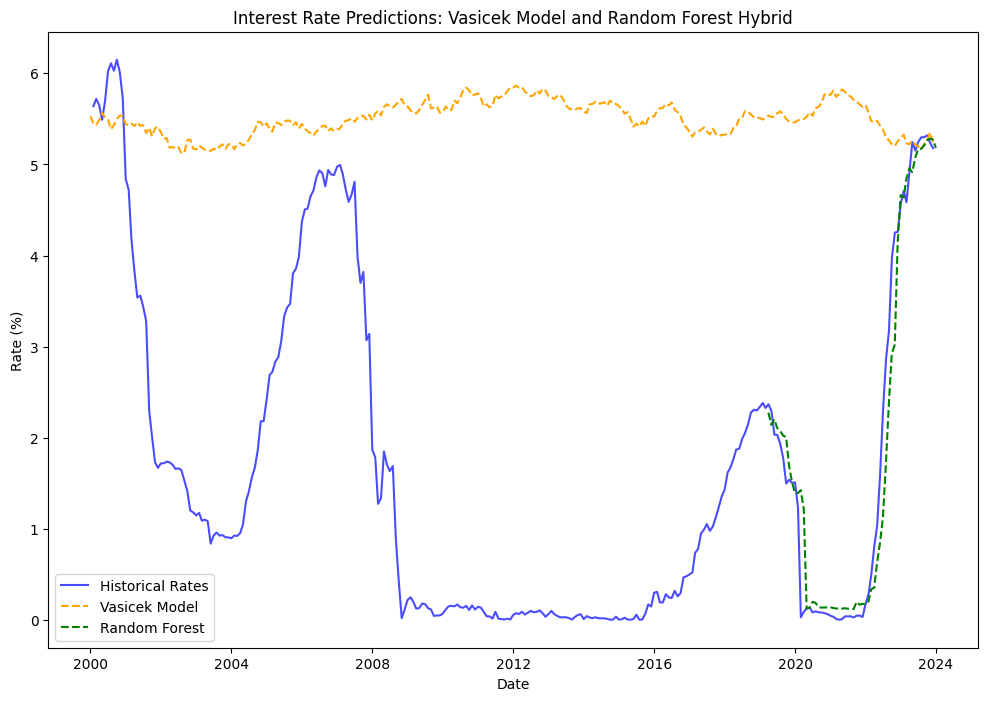

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

# Fetch historical data of the interest rate
ticker = "^IRX"  # This is just an example, you can change it based on your data source
data = yf.download(ticker, start="2000-01-01", end="2024-01-01", interval="1mo")
historical_rates = data['Adj Close'].dropna()

# Vasicek Model Definitions
def vasicek_model(r0, a, b, sigma, T, dt=1/252, rate_floor=0.0):
    n_steps = int(T / dt)
    rates = np.zeros(n_steps)
    rates[0] = r0
    for t in range(1, n_steps):
        dr = a * (b - rates[t - 1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        rates[t] = max(rate_floor, rates[t - 1] + dr)
    return rates

def vasicek_log_likelihood(params, rates, regularization_strength=0.01):
    theta, mu, sigma = params
    dt = 1
    r = rates.values
    log_likelihood = 0
    for t in range(1, len(r)):
        dr = r[t] - r[t-1]
        expected_dr = theta * (mu - r[t-1]) * dt
        likelihood = -0.5 * (np.log(2 * np.pi * sigma**2 * dt) + ((dr - expected_dr)**2) / (sigma**2 * dt))
        log_likelihood += likelihood
    regularization_penalty = regularization_strength * (theta**2 + mu**2 + sigma**2)
    return -log_likelihood + regularization_penalty

# Cross-validation function for parameter optimization
def cross_validate_vasicek(data, initial_guess, n_splits=5, regularization_strength=0.01):
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_score = float('inf')
    best_params = None
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        result = minimize(vasicek_log_likelihood, initial_guess, args=(train_data, regularization_strength),
                          method='L-BFGS-B', bounds=[(0, None), (None, None), (0, None)])
        theta_opt, mu_opt, sigma_opt = result.x
        r0_test = train_data.iloc[-1]
        T_test = len(test_index) / 252
        forecasted_rates = vasicek_model(r0_test, theta_opt, mu_opt, sigma_opt, T_test, dt=1/252)
        from sklearn.metrics import mean_squared_error
        rmse = mean_squared_error(data.iloc[test_index], forecasted_rates[:len(test_index)], squared=False)
        if rmse < best_score:
            best_score = rmse
            best_params = (theta_opt, mu_opt, sigma_opt)
    return best_params

# Optimize parameters for Vasicek model
initial_guess = np.array([0.1, float(historical_rates.mean()), 0.01])
theta_opt, mu_opt, sigma_opt = cross_validate_vasicek(historical_rates, initial_guess)
print(f"Optimized parameters: theta={theta_opt}, mu={mu_opt}, sigma={sigma_opt}")

# Calculate Vasicek Model predictions
forecasted_vasicek = vasicek_model(historical_rates.iloc[0], theta_opt, mu_opt, sigma_opt, T=len(historical_rates)/252)
forecasted_vasicek_series = pd.Series(forecasted_vasicek, index=historical_rates.index)

# Prepare data for Random Forest with Vasicek residuals as additional feature
historical_rates['Forecasted_IRX'] = forecasted_vasicek_series
historical_rates['Residuals'] = historical_rates['^IRX'] - historical_rates['Forecasted_IRX']
historical_rates['Lagged_Residuals'] = historical_rates['Residuals'].shift(1)
historical_rates.dropna(inplace=True)

# Assuming `data_grouped` contains macroeconomic variables like GDP, inflation, etc.
# Merge historical rates with data_grouped (make sure data_grouped aligns on the same index)
# data_grouped = data_grouped.join(historical_rates['Lagged_Residuals'])

# Convert historical_rates index to YearMonth format (yyyy-mm)
historical_rates.index = historical_rates.index.to_period('M')

# Convert data_grouped index to datetime format if needed
# data_grouped.index = pd.to_datetime(data_grouped.index, format='%Y-%m').to_period('M')

# Join data_grouped with the Lagged_Residuals column from historical_rates
data_grouped = data_grouped.join(historical_rates['Lagged_Residuals'])
data_grouped.dropna(inplace=True)

# Convert historical_rates index back to original timestamp format (yyyy-mm-dd)
historical_rates.index = historical_rates.index.to_timestamp()

# Prepare features and target variable
X = data_grouped.drop(columns=['^IRX'])
y = data_grouped['^IRX']  # Target: actual interest rate

# Split data for Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Create a series for Random Forest predictions aligned with test dates
forecasted_rf_series = pd.Series(y_pred_rf, index=y_test.index)

# Plot historical rates, Vasicek model predictions, and Random Forest predictions
plt.figure(figsize=(12, 8))
plt.plot(historical_rates.index, historical_rates['^IRX'], label='Historical Rates', color='blue', alpha=0.7)
plt.plot(forecasted_vasicek_series.index, forecasted_vasicek_series, label='Vasicek Model', color='orange', linestyle='--')
plt.plot(forecasted_rf_series.index, forecasted_rf_series, label='Random Forest', color='green', linestyle='--')

plt.title("Interest Rate Predictions: Vasicek Model and Random Forest Hybrid")
plt.xlabel("Date")
plt.ylabel("Rate (%)")
plt.legend()
plt.show()

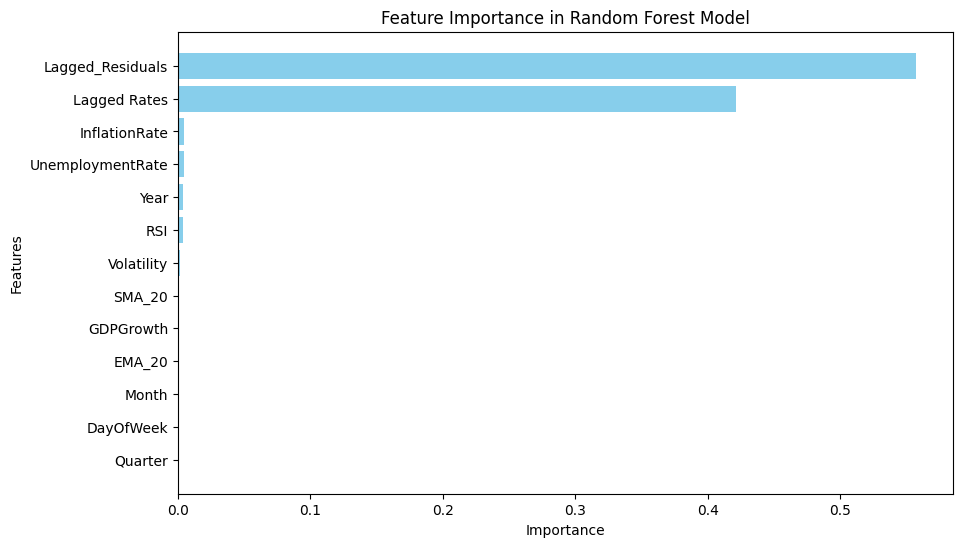

In [12]:
import matplotlib.pyplot as plt

# Extract feature importances from the trained Random Forest model
importances = rf_model.feature_importances_
features = X.columns  # Get feature names from X
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})

# Sort features by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()


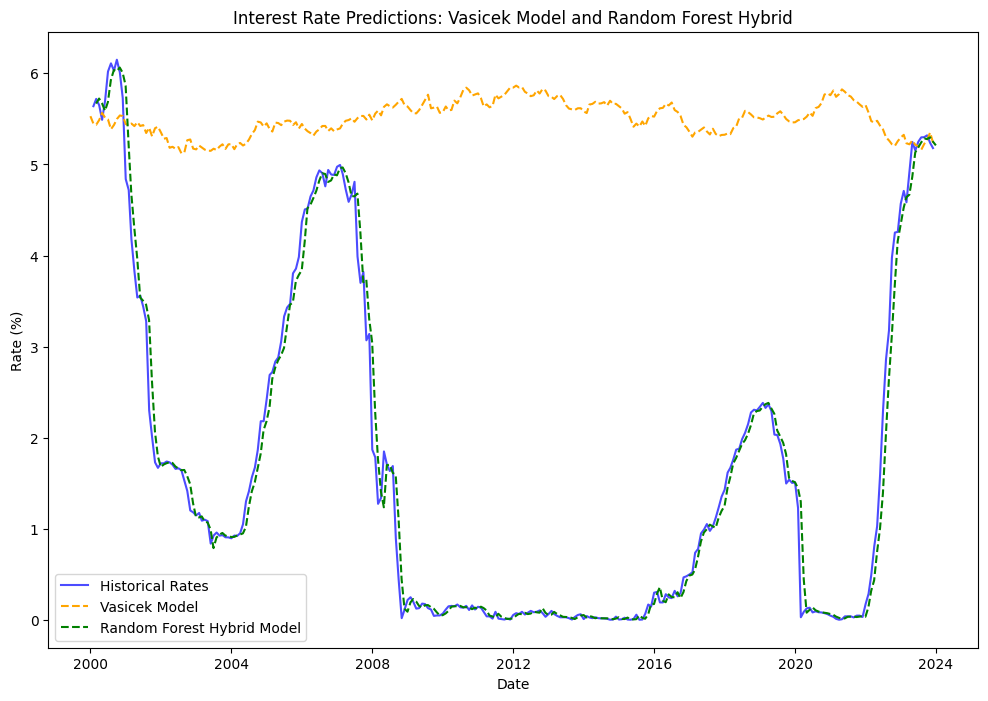

In [13]:
# Train Random Forest Model on full dataset for continuous forecasting
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Generate predictions for the entire series using the Random Forest model
y_pred_rf = rf_model.predict(X)

# Create a series for Random Forest predictions aligned with dates
forecasted_rf_series = pd.Series(y_pred_rf, index=y.index)

# Plot historical rates, Vasicek model predictions, and Random Forest predictions
plt.figure(figsize=(12, 8))
plt.plot(historical_rates.index, historical_rates['^IRX'], label='Historical Rates', color='blue', alpha=0.7)
plt.plot(forecasted_vasicek_series.index, forecasted_vasicek_series, label='Vasicek Model', color='orange', linestyle='--')
plt.plot(forecasted_rf_series.index, forecasted_rf_series, label='Random Forest Hybrid Model', color='green', linestyle='--')

plt.title("Interest Rate Predictions: Vasicek Model and Random Forest Hybrid")
plt.xlabel("Date")
plt.ylabel("Rate (%)")
plt.legend()
plt.show()

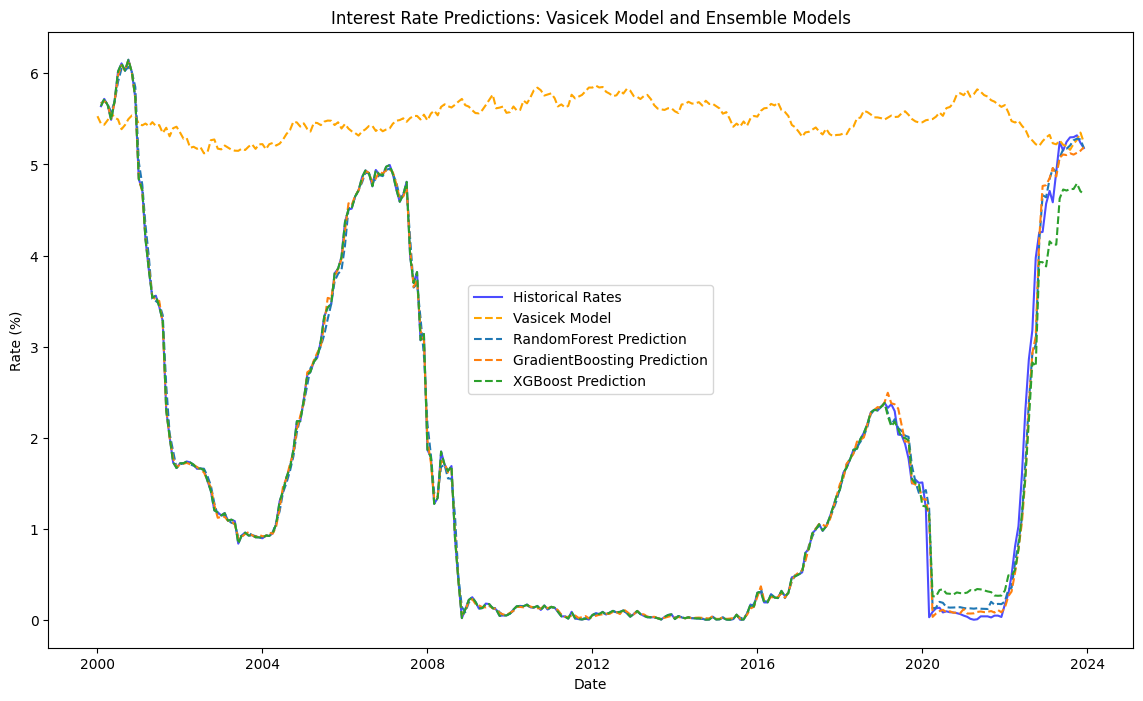

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
}

# Train models and make predictions for the entire data range
model_predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    model_predictions[name] = model.predict(X)

# Plot the results
plt.figure(figsize=(14, 8))
plt.plot(historical_rates.index, historical_rates['^IRX'], label='Historical Rates', color='blue', alpha=0.7)
plt.plot(forecasted_vasicek_series.index, forecasted_vasicek_series, label='Vasicek Model', color='orange', linestyle='--')

# Add each model's predictions to the plot
for name, preds in model_predictions.items():
    plt.plot(historical_rates.index, preds, linestyle='--', label=f'{name} Prediction')

plt.title("Interest Rate Predictions: Vasicek Model and Ensemble Models")
plt.xlabel("Date")
plt.ylabel("Rate (%)")
plt.legend()
plt.show()

                       MAE       MSE      RMSE       R^2
RandomForest      0.061160  0.017547  0.132463  0.994753
GradientBoosting  0.052078  0.015608  0.124933  0.995333
XGBoost           0.067173  0.034351  0.185341  0.989729


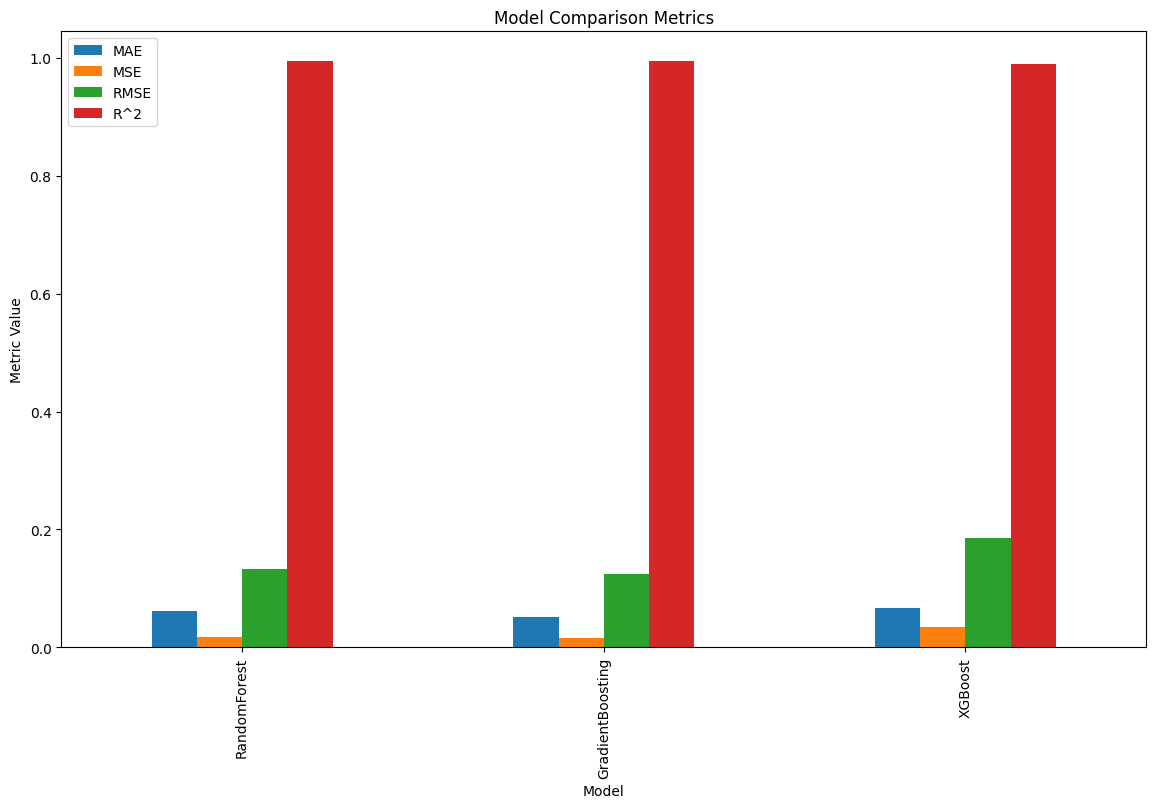

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

# Dictionary to store performance metrics for each model
metrics = {}

# Evaluate each model
for name, preds in model_predictions.items():
    mae = mean_absolute_error(y, preds)
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, preds)
    metrics[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R^2': r2}

# Convert metrics dictionary to a DataFrame for better readability
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

# Plotting the comparison of metrics
metrics_df.plot(kind='bar', figsize=(14, 8), title="Model Comparison Metrics", ylabel="Metric Value", xlabel="Model")
plt.show()


             Feature  Importance
3       Lagged Rates    0.507269
12  Lagged_Residuals    0.451089
5               Year    0.027683
0      InflationRate    0.004670
11               RSI    0.003705
10            EMA_20    0.002618
1          GDPGrowth    0.000929
8         Volatility    0.000685
9             SMA_20    0.000674
2   UnemploymentRate    0.000405
7          DayOfWeek    0.000147
4              Month    0.000125
6            Quarter    0.000000


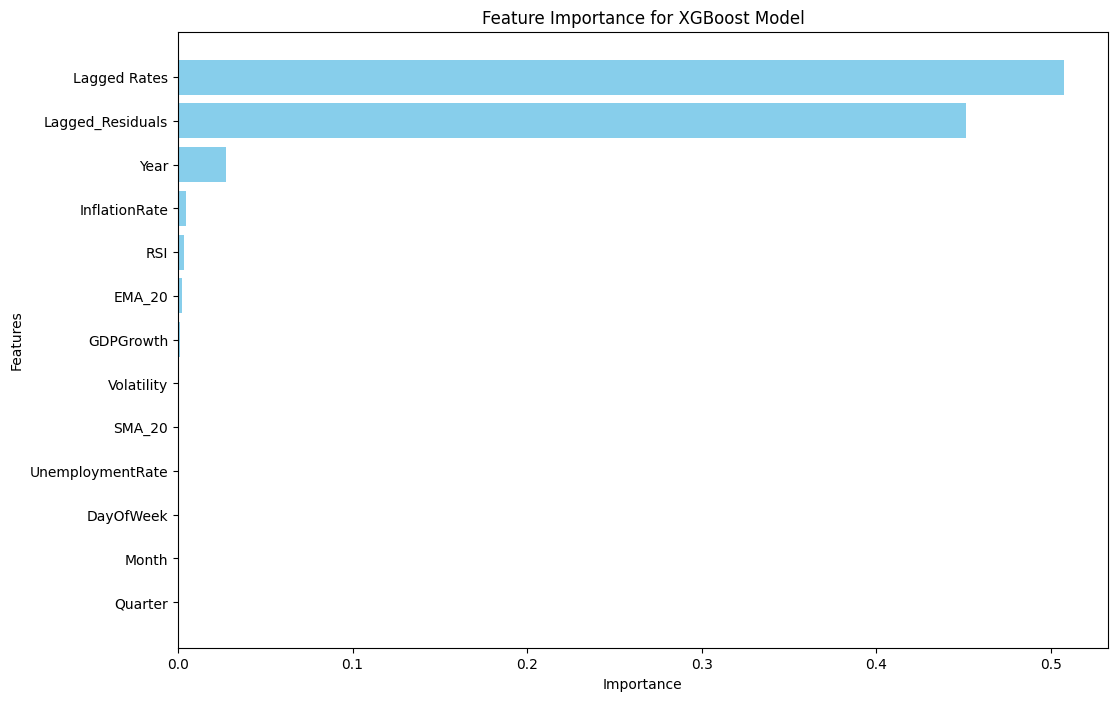

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Fit the XGBoost model
xgboost_model = XGBRegressor(n_estimators=100, random_state=42)
xgboost_model.fit(X_train, y_train)

# Get feature importances
feature_importances = xgboost_model.feature_importances_

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print(importances_df)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance for XGBoost Model")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

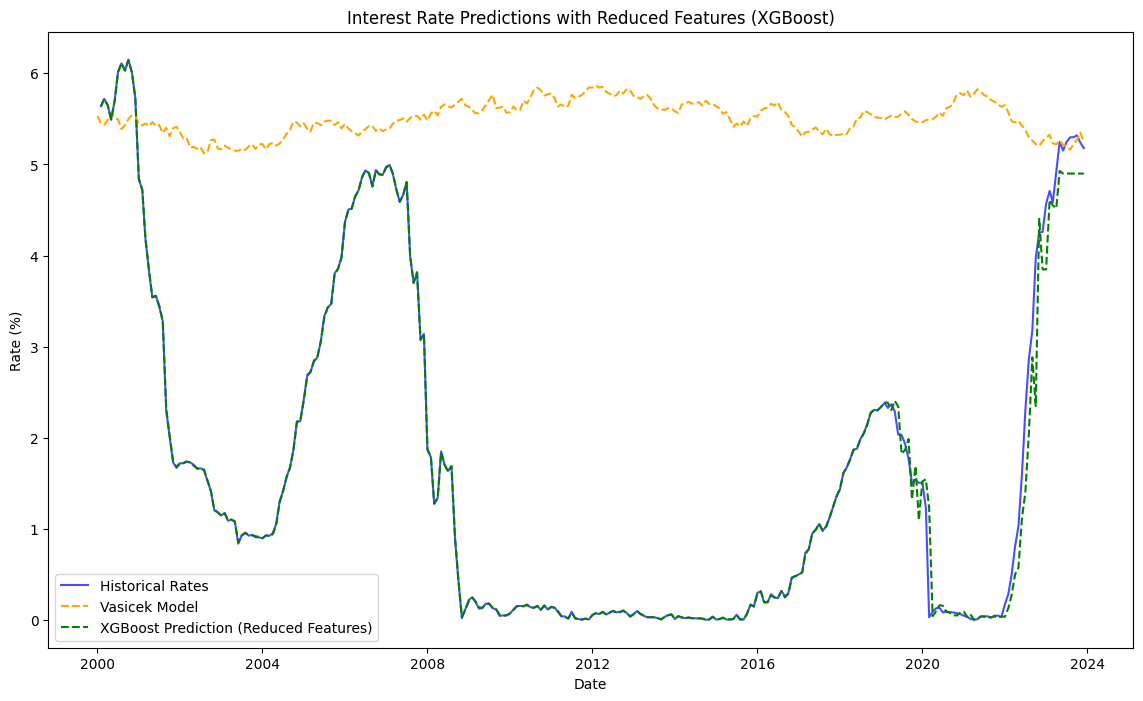

In [17]:
# Select only the important features based on feature importance results
X_important = X[['Lagged Rates', 'Lagged_Residuals']]

# Split data into training and testing with only the selected features
X_train_imp, X_test_imp, y_train, y_test = train_test_split(X_important, y, test_size=0.2, shuffle=False)

# Retrain the XGBoost model with the reduced feature set
xgboost_model_imp = XGBRegressor(n_estimators=100, random_state=42)
xgboost_model_imp.fit(X_train_imp, y_train)

# Make predictions for the entire data range with the reduced feature set
y_pred_xgboost_imp = xgboost_model_imp.predict(X_important)

# Plot the results
plt.figure(figsize=(14, 8))
plt.plot(historical_rates.index, historical_rates['^IRX'], label='Historical Rates', color='blue', alpha=0.7)
plt.plot(forecasted_vasicek_series.index, forecasted_vasicek_series, label='Vasicek Model', color='orange', linestyle='--')
plt.plot(historical_rates.index, y_pred_xgboost_imp, linestyle='--', color='green', label='XGBoost Prediction (Reduced Features)')

plt.title("Interest Rate Predictions with Reduced Features (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Rate (%)")
plt.legend()
plt.show()


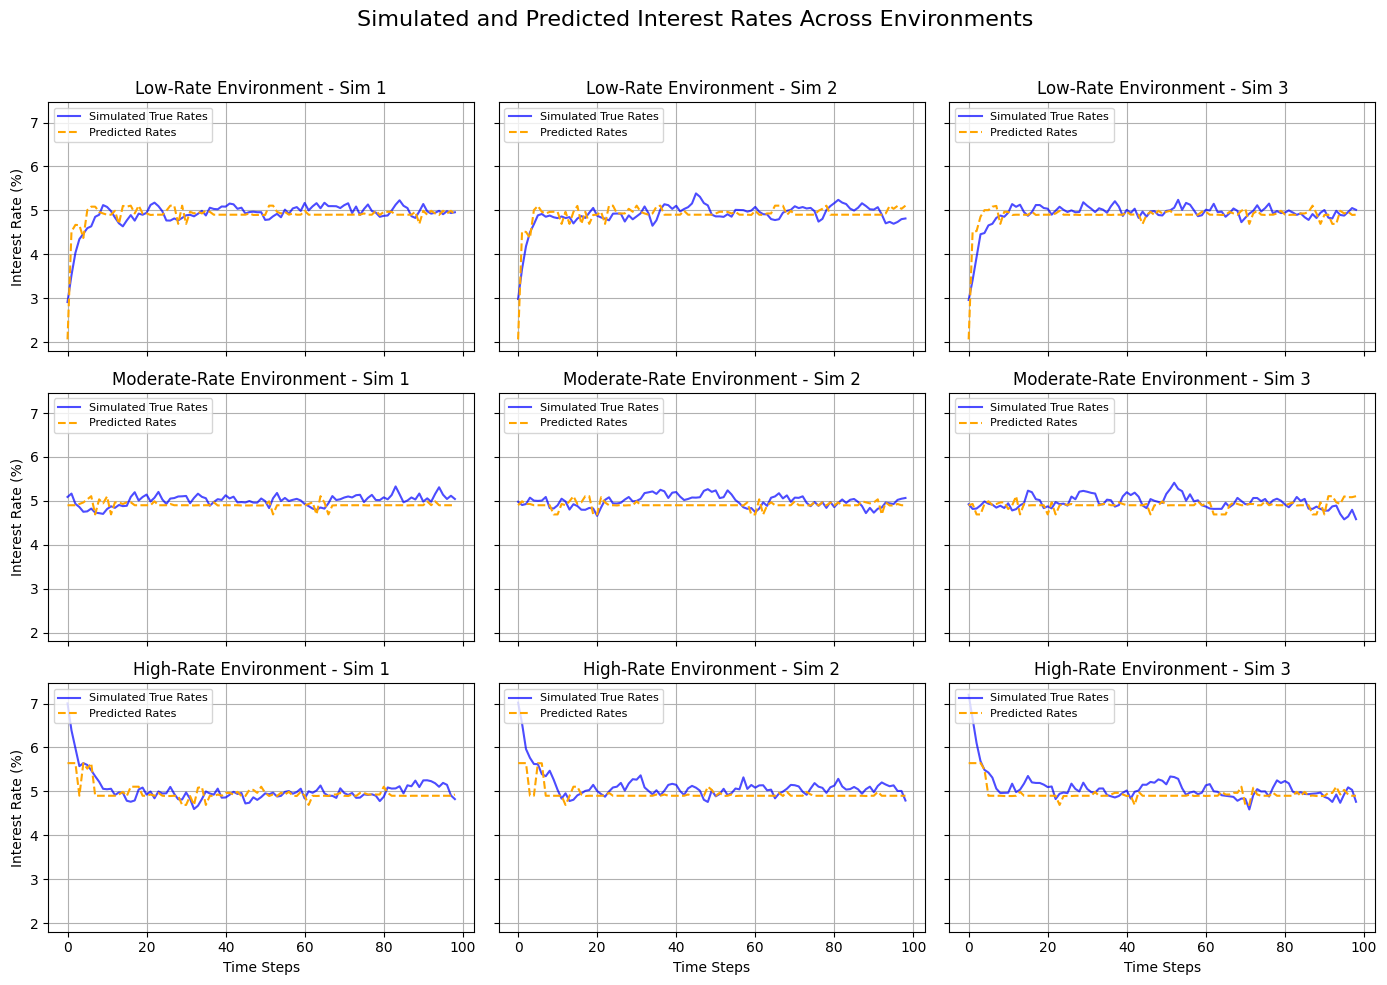

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters for Ornstein-Uhlenbeck (mean-reverting process)
long_term_rate = 5  # Long-term average rate (in %)
volatility = 0.1    # Smaller volatility for gradual changes
mean_reversion_speed = 0.3  # Speed of reversion
n_steps = 100  # Total time steps
n_simulations = 3  # Number of simulations per environment

# Generate Monte Carlo simulations for realistic interest rates
def simulate_interest_rates(start_rate):
    rates = [start_rate]
    for t in range(1, n_steps):
        # Mean-reverting Ornstein-Uhlenbeck process
        drift = mean_reversion_speed * (long_term_rate - rates[-1])
        shock = np.random.normal(0, volatility)
        rates.append(rates[-1] + drift + shock)
    return np.array(rates)

# Generate simulated environments
environments = {
    "Low-Rate Environment": 2,
    "Moderate-Rate Environment": 5,
    "High-Rate Environment": 8
}

results = {env: [] for env in environments}
for env, start_rate in environments.items():
    for _ in range(n_simulations):
        rates = simulate_interest_rates(start_rate)
        residuals = np.random.normal(0, 0.05, size=n_steps)  # Small residual noise
        results[env].append((rates, residuals))

# Predictions for each environment
predictions = {env: [] for env in environments}
true_rates = {env: [] for env in environments}

for env, simulations in results.items():
    for rates, residuals in simulations:
        df = pd.DataFrame({
            'Lagged Rates': rates[:-1],
            'Lagged_Residuals': residuals[:-1],
        })
        df['Predicted Rates'] = xgboost_model_imp.predict(df[['Lagged Rates', 'Lagged_Residuals']])
        df['True Rates'] = rates[1:]
        predictions[env].append(df['Predicted Rates'].values)
        true_rates[env].append(df['True Rates'].values)

# Visualization: Grid of smaller figures for environments and simulations
fig, axes = plt.subplots(3, n_simulations, figsize=(14, 10), sharex=True, sharey=True)
fig.suptitle("Simulated and Predicted Interest Rates Across Environments", fontsize=16)

env_names = list(environments.keys())

for i, env in enumerate(env_names):
    for j in range(n_simulations):
        ax = axes[i, j]
        ax.plot(true_rates[env][j], label="Simulated True Rates", color="blue", alpha=0.7)
        ax.plot(predictions[env][j], label="Predicted Rates", color="orange", linestyle="--")
        ax.set_title(f"{env} - Sim {j + 1}")
        ax.grid()
        if i == 2:
            ax.set_xlabel("Time Steps")
        if j == 0:
            ax.set_ylabel("Interest Rate (%)")
        ax.legend(loc="upper left", fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()